### Predictive Analytics

In [2]:
%matplotlib inline

# general libs
import sys
import numpy as np
import pandas as pd
import sklearn
import scipy

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter

# date time libs
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm 

# ml libs
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# CSS Fileb
from IPython.core.display import HTML
from IPython.display import Image

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css));

In [3]:
# Functions....
def read_metric_data(csv_name):
    '''
        Read data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
    print("{0} --- #(rows:columns): {1}".format(csv_name, df.shape))
    return df

def get_days_forecast(df, freecapacity):
    daysleft = 0
    availcap = freecapacity
    while availcap >= 0:
        usage = np.random.choice(df, 1, replace=True)
        availcap = availcap - usage
        daysleft = daysleft + 1
    return daysleft

def montecarlo_days_forecast(df, freecapacity, iterations=10000):    
    # Init
    lastday = df.index[-1]
    days_s = pd.Series(np.zeros(iterations, dtype=int), name='days_s')
    dates_s = pd.Series(np.zeros(iterations), name='dates_s')
    
    #Forecast days & dates
    for i in range(iterations):
        days_s[i] = get_days_forecast(df, freecapacity)
        dates_s[i] = lastday + timedelta(days_s[i])
    days_s = days_s.dropna()
    dates_s = dates_s.sort_values()
    return (days_s, dates_s)


def get_usage_forecast(df, days=100):
    s = pd.Series(np.zeros(days, dtype=float), name='capacity_usage')
    s[0] = 0
    for i in range(1, days+1):
        usage = np.random.choice(df, 1, replace=True)
        s[i] = s[i-1]+usage
    #pd.to_numeric(s, errors='coerce')
    return s

def montecarlo_usage_forecast(df, days=100, iterations=10000):
    lastday = df.index[-1]
    cap_index = pd.date_range(lastday, periods=days+1, freq='D')
    cap_usage_df = pd.DataFrame(index=cap_index)
    
    for i in range(iterations):
        series  = get_usage_forecast(df, days)
        series.index = cap_index
        cap_usage_df.loc[:, i] = series
        
    cap_usage_df = cap_usage_df.dropna()
    return cap_usage_df


In [7]:
#Plots
def create_trend_plot(xlabel, ylabel, title, df):
    # Create line chart
    fig = plt.figure(figsize=(14, 5))
    ax = plt.gca()
    ax.xaxis.set_major_locator(DayLocator(interval=7))
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) # TimeFormat : http://strftime.org/
    plt.plot(df.total, color='gray', linewidth=3, linestyle= '--', label='Total Capacity')
    plt.plot(df.used, color='steelblue', label='Capacity Used')
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title)
    plt.legend(loc='best')
    plt.gcf().autofmt_xdate()
    return

def create_shape_plots(xlabel, ylabel, title, df):
    #Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    # Box-Whiskers Plot
    x = df.pivot(columns='week_days', values='diff')
    x = x.rename(columns={0: 'Mon', 1: 'Tue', 2:'Wed', 3:'Thur', 4:'Fri', 5:'Sat', 6:'Sun'})
    g1 = sns.violinplot(data=x, palette=sns.color_palette(), split=True, ax=axes[0])
    g1.set_xlabel(xlabel, fontweight='bold', fontsize=12)
    g1.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    g1.set_title(title)

    # Swarm Plot
    g2 = sns.stripplot(data=df['diff'], jitter=True, size=4, color=".1", linewidth=0, ax=axes[1])
    g3 = sns.violinplot(data=df['diff'], palette=sns.color_palette(), split=True, ax=axes[1])
    g3.set_xlabel('')
    g3.set_ylabel(ylabel, fontweight='bold', fontsize=12)
    g3.set_title(title)
    return

def create_ecdf_plots(ylabel, title, cap_full_days, cap_full_dates):
    #Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    ecdf1 = sm.distributions.ECDF(cap_full_days)
    x1 = np.linspace(min(cap_full_days), max(cap_full_days))
    y1 = ecdf1(x1)
    
    ecdf2 = sm.distributions.ECDF(cap_full_dates)
    x2 = cap_full_dates
    y2 = ecdf2(x2)
    
    axes[0].step(x1, y1)
    axes[0].set_title(title)
    axes[0].set_xlabel("Days", fontweight='bold')
    axes[0].set_ylabel(ylabel, fontweight='bold')
    
    axes[1].step(x2, y2)
    axes[1].set_title(title)
    axes[1].set_xlabel("Date", fontweight='bold')
    axes[1].set_ylabel(ylabel, fontweight='bold')
    plt.gcf().autofmt_xdate()
    return

def create_forecast_plot(xlabel, ylabel, title, df):
    # Create line chart
    fig = plt.figure(figsize=(14, 5))
    ax = plt.gca()
    #ax.xaxis.set_major_locator(DayLocator(interval=7))
    #ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) # TimeFormat : http://strftime.org/
    plt.plot(df, color='slategray', label='Capacity Used')
    plt.xlabel(xlabel, fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title)
    plt.gcf().autofmt_xdate()
    return


In [1]:
#HTML('''<script>
#code_show=true; 
#function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
#} 
#$( document ).ready(code_toggle);
#</script>
#<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

#### Reading Data...

In [4]:
# Read capacity used metric
df_used = read_metric_data("data\capacity\dogfood-v1-capused-d.txt")
df_used = df_used.drop("server", axis=1)
df_used = df_used.dropna()
df_used['value'] = df_used.value/(1024*1024*1024)  # convert to GB from bytes
df_used['diff'] = df_used.value.diff()
df_used.round(2)

# Read capacity total metric
df_total = read_metric_data("data\capacity\dogfood-v1-captotal-d.txt")
df_total = df_total.dropna()
df_total = df_total.drop('server', axis = 1)
df_total['value'] = df_total.value/(1024*1024*1024)  # convert to GB from bytes
df_total.round(2)

df_trend = pd.DataFrame(index=df_used.index)
df_trend['total'] = df_total.value
df_trend['used'] = df_used.value
df_trend.round(2)

df_diff = pd.DataFrame(index= df_used.index)
df_diff['diff'] = df_used['diff']
df_diff = df_diff.dropna()
df_diff['week_days'] = df_diff.index.weekday

data\capacity\dogfood-v1-capused-d.txt --- #(rows:columns): (92, 2)
data\capacity\dogfood-v1-captotal-d.txt --- #(rows:columns): (92, 2)


#### Generating Analytics...

In [11]:
totalcap = df_total.value.iloc[1]
usedcap = df_used.value.iloc[-1]
freecapacity = totalcap - usedcap

cap_full_days, cap_full_dates = montecarlo_days_forecast(df_diff['diff'], freecapacity, simulations)
cap_usage_df = montecarlo_usage_forecast(df_diff['diff'], days, simulations)

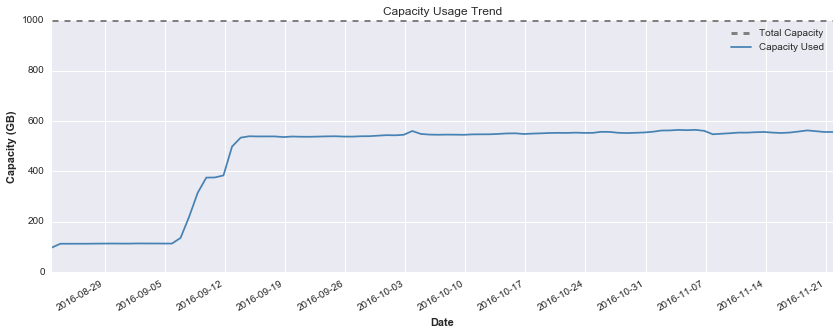

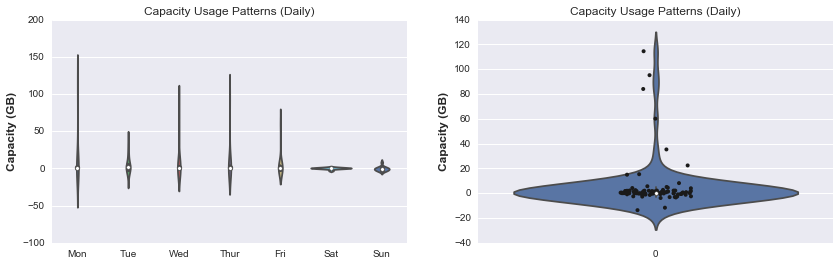

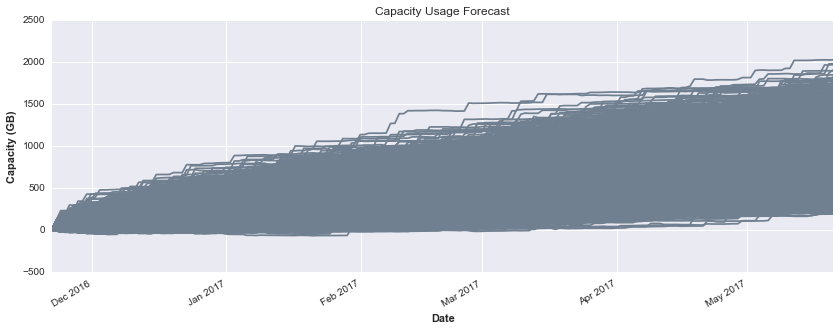

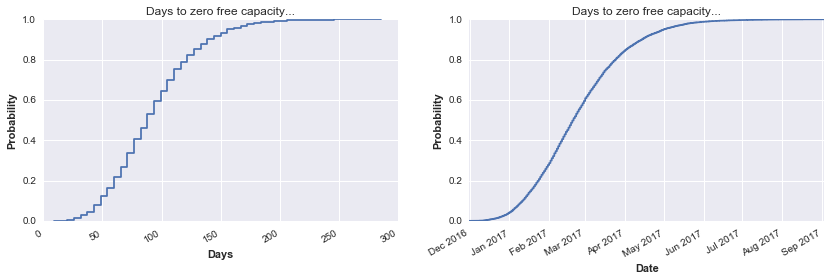

In [12]:
create_trend_plot("Date", "Capacity (GB)", "Capacity Usage Trend", df_trend)
create_shape_plots("","Capacity (GB)", "Capacity Usage Patterns (Daily)", df_diff)
create_forecast_plot("Date", "Capacity (GB)", "Capacity Usage Forecast", cap_usage_df)
create_ecdf_plots("Probability","Days to zero free capacity...", cap_full_days, cap_full_dates)